In [2]:
#Importing necessary libraries
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
import librosa
import os
import librosa.display
from skimage.io import imread
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_text
from sklearn.inspection import permutation_importance

C:\Users\19147\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
import pandas as pd

# Load the CSV file
metadata_path = "C:/Users/19147/Downloads/archive (12)/bird_songs_metadata.csv"
df = pd.read_csv(metadata_path)

# Display the first few rows of the dataframe 
df.head()


,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
0,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-0.wav
1,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-1.wav
2,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-4.wav
3,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-5.wav
4,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-6.wav


In [4]:
#distribution of species
species_dist = df['species'].value_counts()
print(species_dist)

species
melodia        1256
polyglottos    1182
cardinalis     1074
migratorius    1017
bewickii        893
Name: count, dtype: int64


In [5]:
# Checking for missing values in each column
missing_values = df.isnull().sum()
print(missing_values)

id               0
genus            0
species          0
subspecies    3876
name             0
recordist        0
country          0
location         0
latitude        90
longitude       90
altitude        42
sound_type       0
source_url       0
license          0
time             0
date             0
remarks       1859
filename         0
dtype: int64


The primary input for generating spectrograms is the audio file itself. Missing values in metadata (like subspecies, latitude, longitude, altitude, and remarks) won't affect the generation of spectrograms, as long as the audio files (filename) are intact and not missing. 

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5422 entries, 0 to 5421
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          5422 non-null   int64  
 1   genus       5422 non-null   object 
 2   species     5422 non-null   object 
 3   subspecies  1546 non-null   object 
 4   name        5422 non-null   object 
 5   recordist   5422 non-null   object 
 6   country     5422 non-null   object 
 7   location    5422 non-null   object 
 8   latitude    5332 non-null   float64
 9   longitude   5332 non-null   float64
 10  altitude    5380 non-null   object 
 11  sound_type  5422 non-null   object 
 12  source_url  5422 non-null   object 
 13  license     5422 non-null   object 
 14  time        5422 non-null   object 
 15  date        5422 non-null   object 
 16  remarks     3563 non-null   object 
 17  filename    5422 non-null   object 
dtypes: float64(2), int64(1), object(15)
memory usage: 762.6+ KB
None


**Feature Extraction**

In [7]:

def load_bird_sound_paths_from_csv(metadata_path, audio_files_path):
    df = pd.read_csv(metadata_path)
    file_paths = []
    labels = []

    for index, row in df.iterrows():
        file_path = os.path.join(audio_files_path, row['filename'])
        if os.path.exists(file_path):
            file_paths.append(file_path)
            labels.append(row['species'])  # 'species' holds the label
        else:
            print(f"File not found: {file_path}")

    return file_paths, labels

# Usage
metadata_path = "C:/Users/19147/Downloads/archive (12)/bird_songs_metadata.csv"
audio_files_path =  "C:/Users/19147/Downloads/archive (12)/wavfiles"

file_paths, labels = load_bird_sound_paths_from_csv(metadata_path, audio_files_path)
print(file_paths[:5], labels[:5])


['C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-0.wav', 'C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-1.wav', 'C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-4.wav', 'C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-5.wav', 'C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-6.wav'] ['bewickii', 'bewickii', 'bewickii', 'bewickii', 'bewickii']


In [8]:
# New function to load and process audio files from paths
def load_and_process_audio(file_paths, sr, fixed_length):
    processed_audio = []
    for file_path in file_paths:
        sound, _ = librosa.load(file_path, sr=None)
        if len(sound) > fixed_length:
            sound = sound[:fixed_length]
        else:
            padding = fixed_length - len(sound)
            sound = np.pad(sound, (0, padding), 'constant')
        processed_audio.append(sound)
    return processed_audio



In [9]:
# Variables
sr = 22050  # Default sampling rate from librosa
fixed_length = 5 * sr  # 5 seconds multiplied by sampling rate

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)

def extract_log_mel_spectrogram(file_path, sr, n_fft=2048, hop_length=512, n_mels=128):
    # Load audio file
    audio, sr = librosa.load(file_path,sr=None)
    
    # Calculate Mel spectrogram
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    S_DB = librosa.power_to_db(S, ref=np.max)  # Convert the Mel spectrogram to logarithmic scale (decibels)
    
    return S_DB  # Return the log Mel spectrogram data directly


log_mel_spectrogram = extract_log_mel_spectrogram(file_paths[0], sr)

In [10]:
log_mel_features_list = []
# Loop through each file path and extract features
for file_path in file_paths:
    log_mel_features = extract_log_mel_spectrogram(file_path,sr)
    log_mel_features_list.append(log_mel_features)
# Convert lists to numpy arrays for further processing 
log_mel_features_array = np.array(log_mel_features_list)


In [11]:
# Flatten each Mel spectrogram before adding to the list
log_mel_features_list = [mel_feature.flatten() for mel_feature in log_mel_features_list]
X1_train, X1_test, y1_train, y1_test, files1_train, files1_test = train_test_split(
    log_mel_features_list, y_encoded, file_paths, test_size=0.2, random_state=42
)

clf_log_Mel = RandomForestClassifier(random_state=42)
clf_log_Mel.fit(X1_train, y1_train)
clf_log_Mel_predictions = clf_log_Mel.predict(X1_test)

# Print accuracy and classification report
print(f"Accuracy with Mel features: {accuracy_score(y1_test, clf_log_Mel_predictions)}")
print(f"Classification Report: \n{classification_report(y1_test, clf_log_Mel_predictions, target_names=label_encoder.classes_)}\n")

Accuracy with Mel features: 0.719815668202765
Classification Report: 
              precision    recall  f1-score   support

    bewickii       0.78      0.64      0.70       193
  cardinalis       0.67      0.74      0.70       204
     melodia       0.68      0.82      0.74       243
 migratorius       0.80      0.74      0.77       207
 polyglottos       0.72      0.64      0.68       238

    accuracy                           0.72      1085
   macro avg       0.73      0.72      0.72      1085
weighted avg       0.73      0.72      0.72      1085




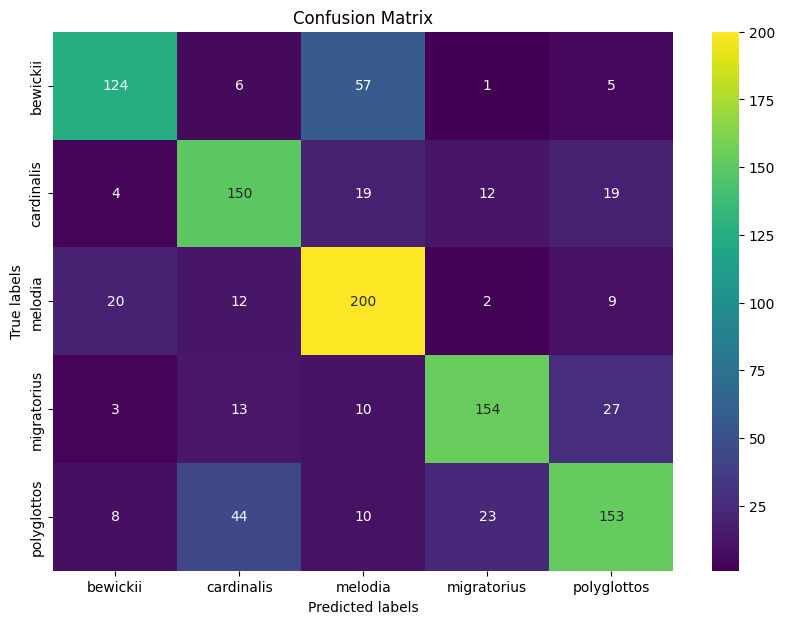

[[124   6  57   1   5]
 [  4 150  19  12  19]
 [ 20  12 200   2   9]
 [  3  13  10 154  27]
 [  8  44  10  23 153]]


In [12]:
cm_Mel = confusion_matrix(y1_test, clf_log_Mel_predictions)

# Plotting using seaborn 
plt.figure(figsize=(10, 7))
sns.heatmap(cm_Mel, annot=True, fmt='g', cmap='viridis', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
print(cm_Mel)

In [13]:
log_Mel_prob = clf_log_Mel.predict_proba(X1_test)
max_probs = np.max(log_Mel_prob, axis=1)
top_10_indices_log_Mel = np.argsort(-max_probs)[:10]  
print(top_10_indices_log_Mel )

[328 492 826 578   7 935 350  74 924 149]


Spectrogram shape: (128, 130)


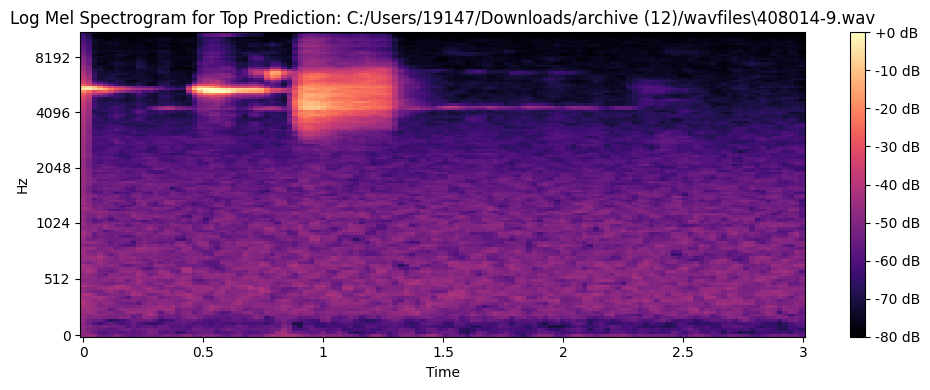

Spectrogram shape: (128, 130)


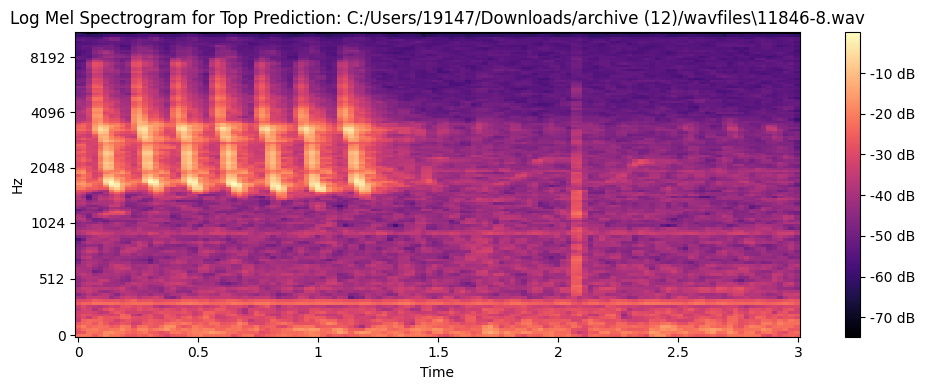

Spectrogram shape: (128, 130)


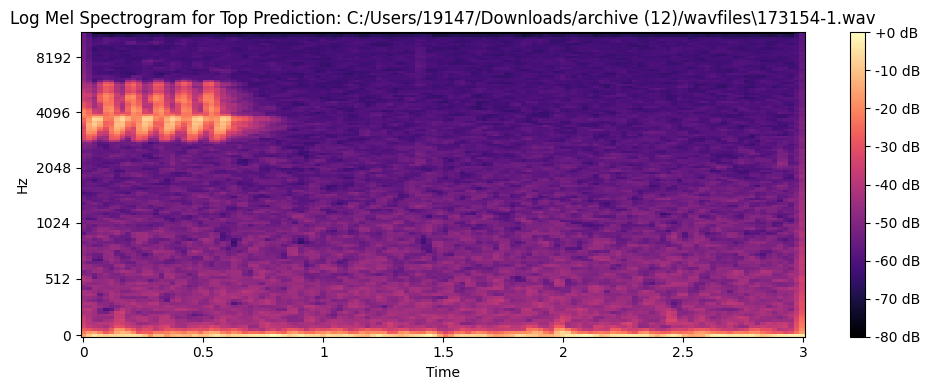

Spectrogram shape: (128, 130)


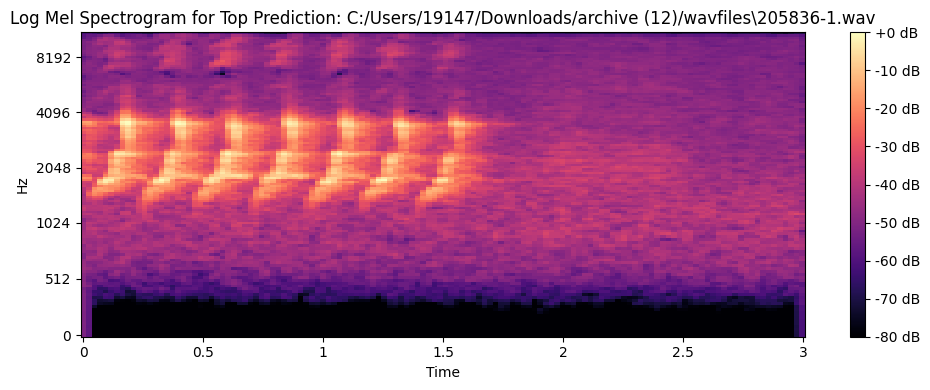

Spectrogram shape: (128, 130)


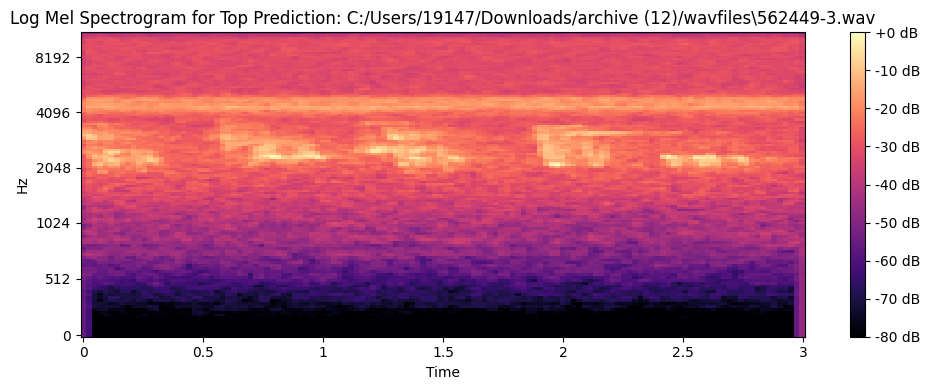

Spectrogram shape: (128, 130)


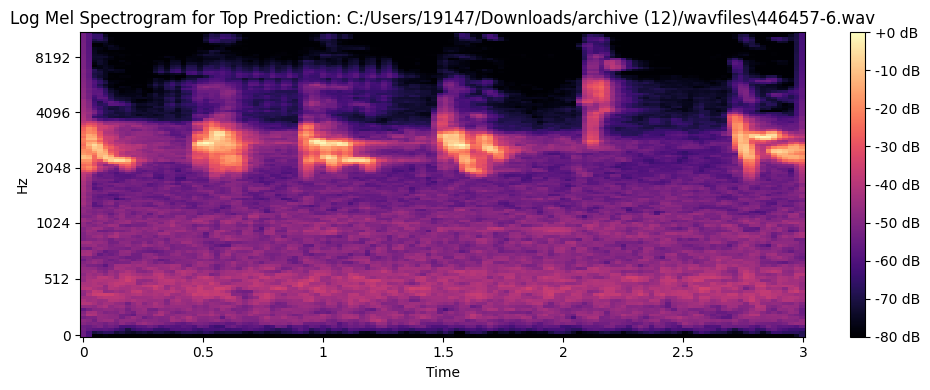

Spectrogram shape: (128, 130)


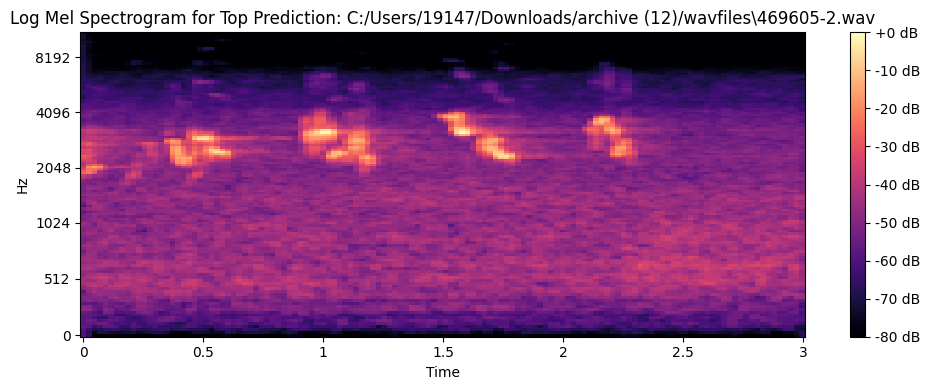

Spectrogram shape: (128, 130)


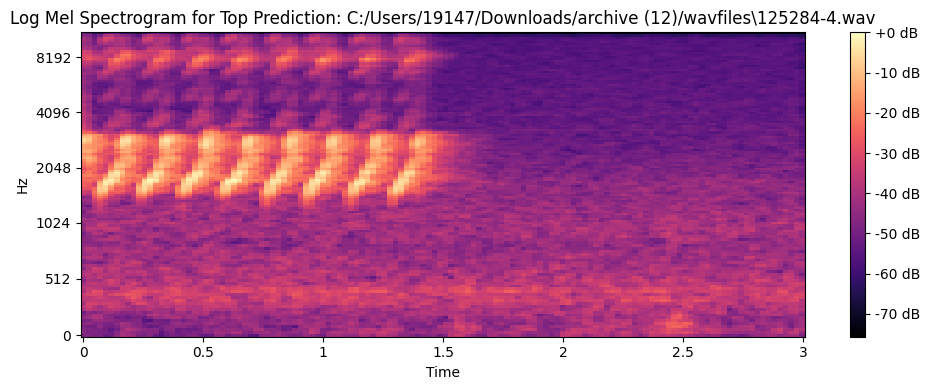

Spectrogram shape: (128, 130)


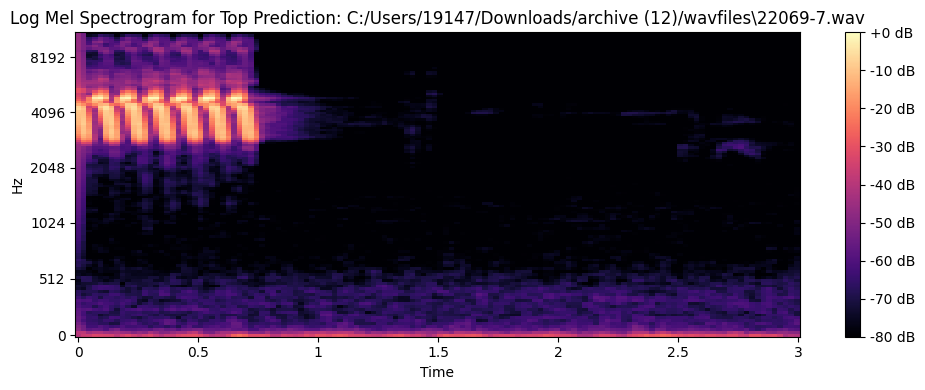

Spectrogram shape: (128, 130)


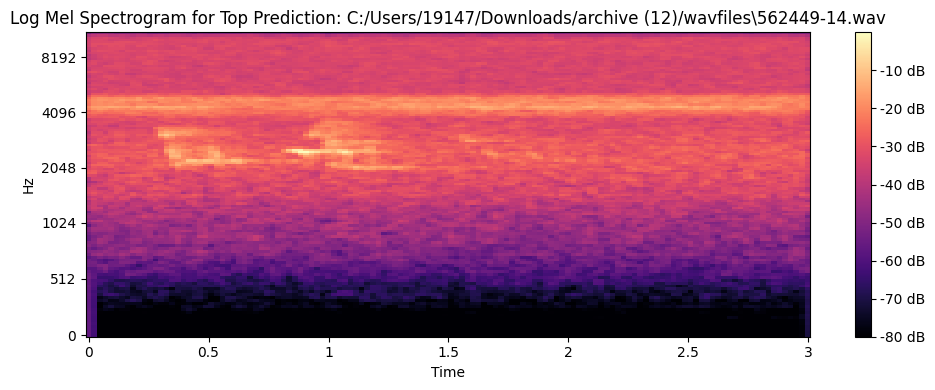

In [14]:
def plot_log_mel_spectrogram(spectrogram, title, sr=22050):
    print("Spectrogram shape:", spectrogram.shape)  
    if spectrogram.ndim != 2:
        raise ValueError("Spectrogram must be a 2D array.")
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='mel', hop_length=512)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Iterate over the top 10 indices and plot the log Mel spectrogram for each
for index in top_10_indices_log_Mel:
    log_mel_spectrogram = X1_test[index]  
    if log_mel_spectrogram.ndim == 1:  
        num_mels = 128  
        time_steps = len(log_mel_spectrogram) // num_mels
        log_mel_spectrogram = log_mel_spectrogram.reshape(num_mels, time_steps)
    file_path = files1_test[index]
    plot_title = f'Log Mel Spectrogram for Top Prediction: {file_path}'
    plot_log_mel_spectrogram(log_mel_spectrogram, plot_title)

In [15]:
bottom_10_indices_log_Mel = np.argsort(max_probs)[:10]  
print(bottom_10_indices_log_Mel)

[ 543  311  500  574  249  634 1079  184  374  977]


Spectrogram shape: (128, 130)


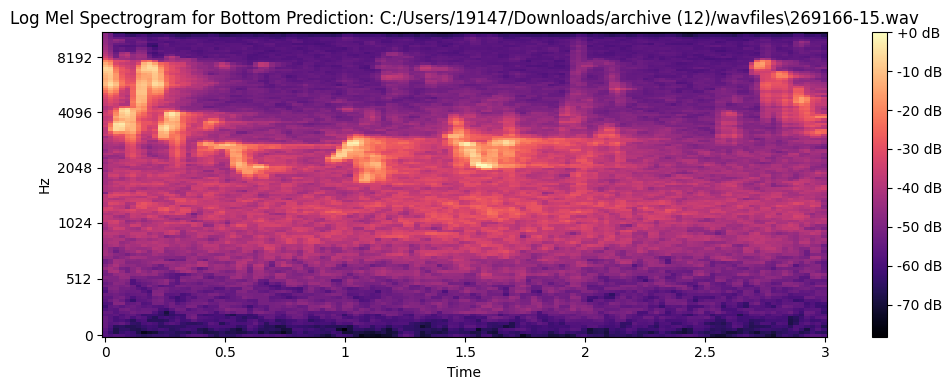

Spectrogram shape: (128, 130)


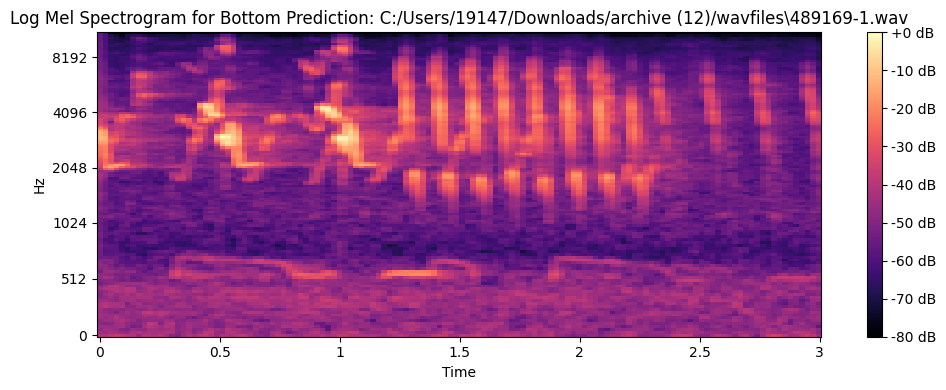

Spectrogram shape: (128, 130)


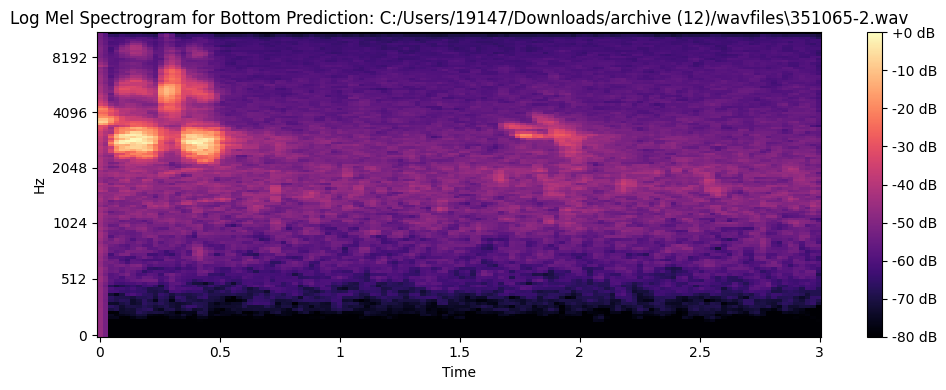

Spectrogram shape: (128, 130)


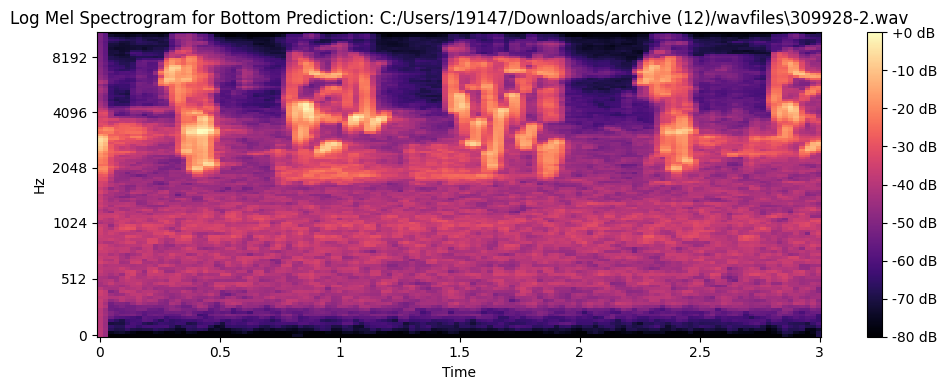

Spectrogram shape: (128, 130)


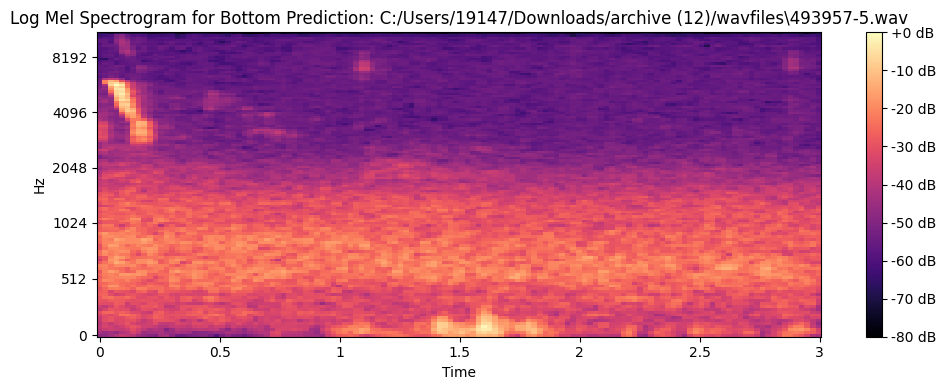

Spectrogram shape: (128, 130)


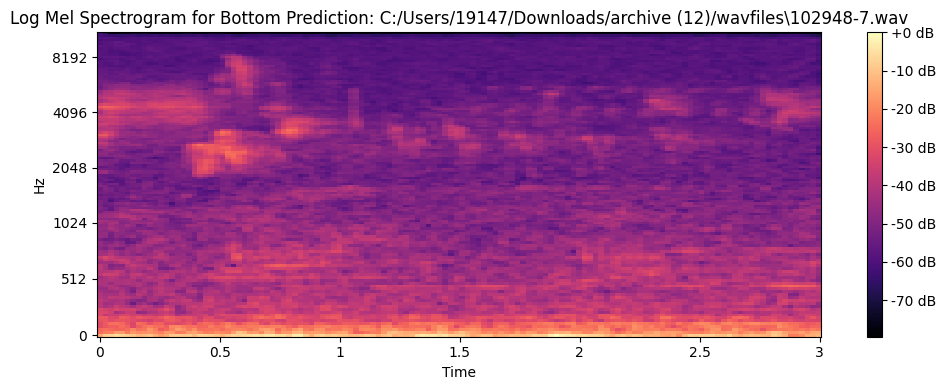

Spectrogram shape: (128, 130)


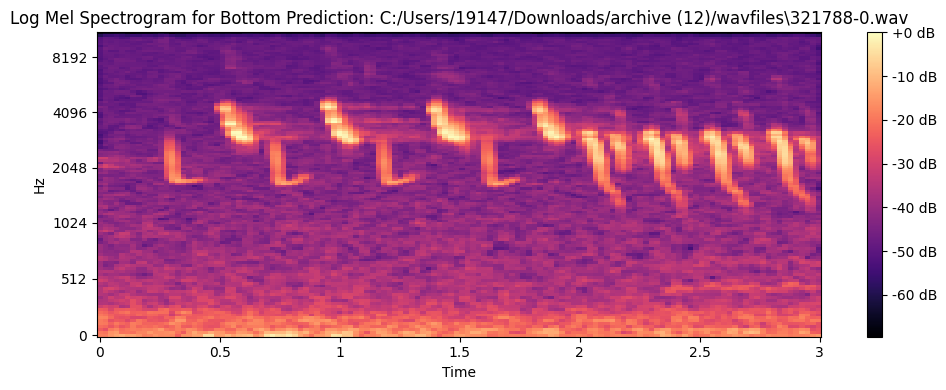

Spectrogram shape: (128, 130)


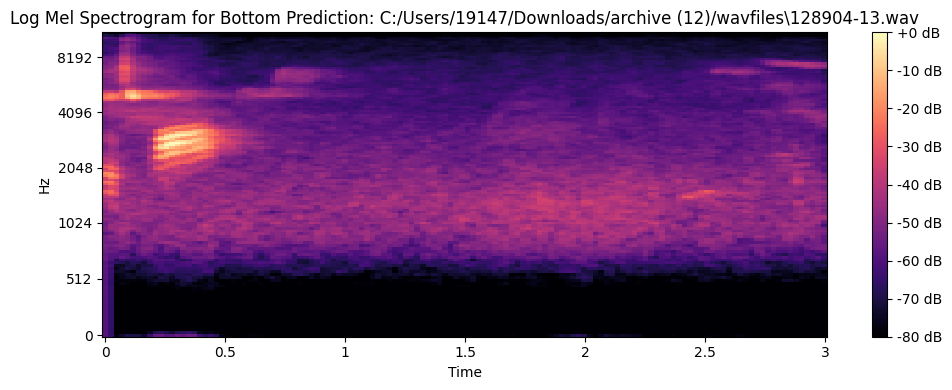

Spectrogram shape: (128, 130)


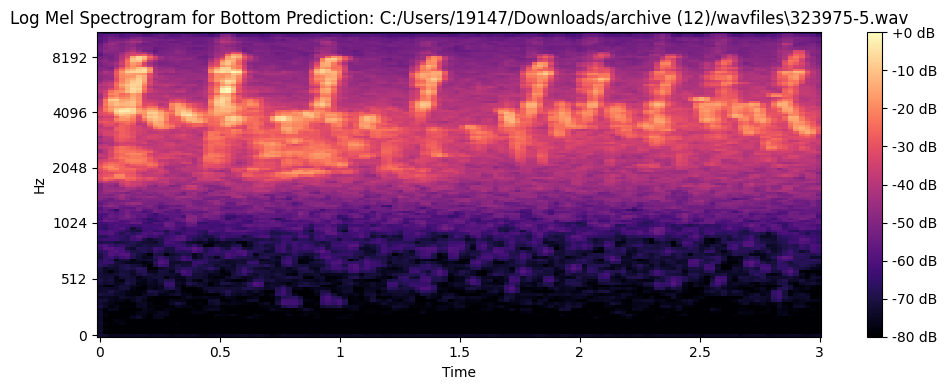

Spectrogram shape: (128, 130)


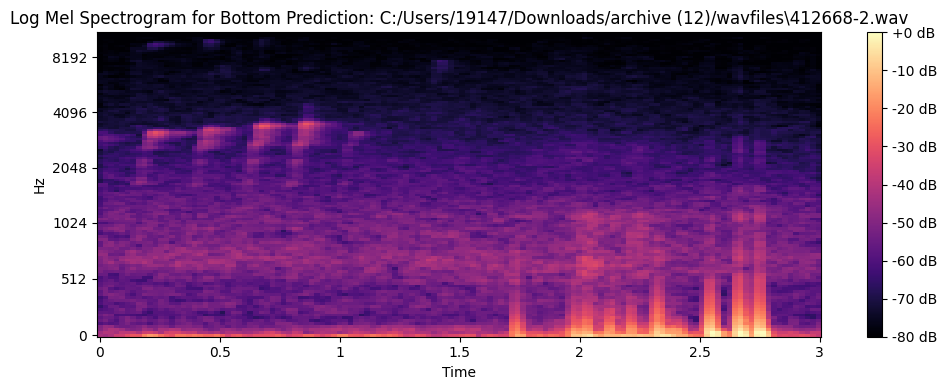

In [16]:
# Iterate over the bottom 10 indices and plot the log Mel spectrogram for each
for index in bottom_10_indices_log_Mel:
    log_mel_spectrogram = X1_test[index]
    if log_mel_spectrogram.ndim == 1:
        num_mels = 128
        time_steps = len(log_mel_spectrogram) // num_mels
        log_mel_spectrogram = log_mel_spectrogram.reshape(num_mels, time_steps)
    file_path = files1_test[index]
    plot_title = f'Log Mel Spectrogram for Bottom Prediction: {file_path}'
    plot_log_mel_spectrogram(log_mel_spectrogram, plot_title)


In [17]:
incorrect_indices_log_Mel = np.where(clf_log_Mel_predictions != y1_test)[0]
print(incorrect_indices_log_Mel)

[  11   15   17   26   29   33   34   35   37   43   44   49   52   53
   57   61   63   67   68   69   70   72   77   82   89   91   99  102
  106  109  110  114  121  122  128  129  132  133  135  136  143  145
  151  154  155  158  162  167  171  174  179  182  184  188  190  191
  192  195  198  199  201  202  205  206  221  223  226  230  231  233
  238  239  240  245  246  249  255  269  270  279  280  283  285  287
  289  290  294  295  303  304  307  313  318  320  321  323  324  327
  329  330  333  336  342  346  349  364  367  370  373  376  383  390
  391  398  399  400  404  405  408  410  411  413  432  433  437  442
  443  445  452  453  454  455  459  477  478  486  487  493  498  507
  509  513  514  517  519  520  522  531  532  535  537  543  554  558
  562  568  572  573  574  576  577  579  581  587  588  590  593  603
  604  606  609  611  620  621  622  626  631  638  650  652  658  659
  660  662  674  680  683  686  687  693  694  702  703  705  707  711
  713 

Spectrogram shape: (128, 130)


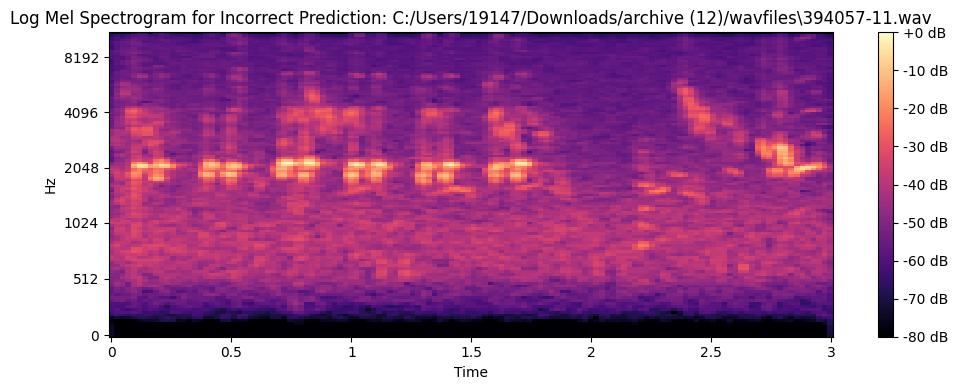

Spectrogram shape: (128, 130)


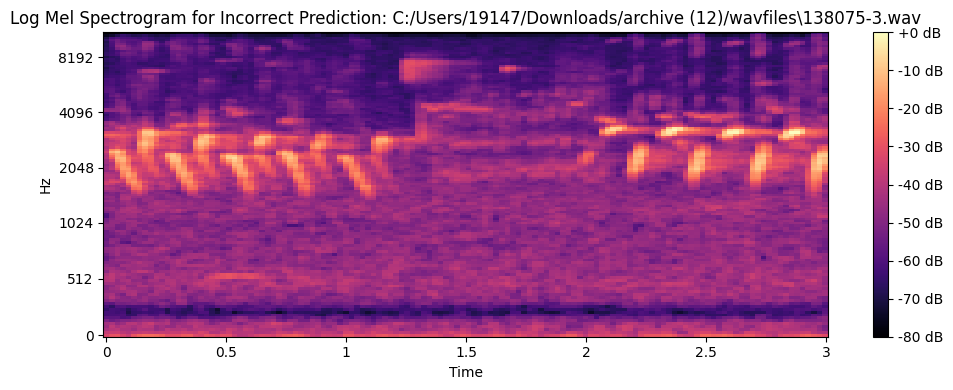

Spectrogram shape: (128, 130)


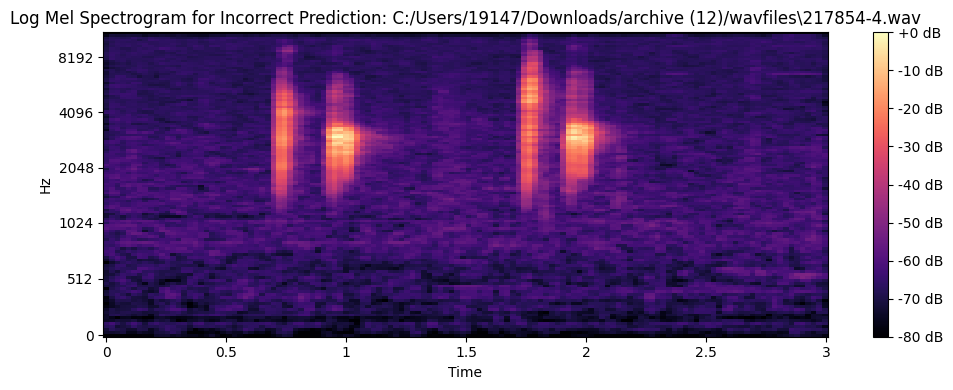

Spectrogram shape: (128, 130)


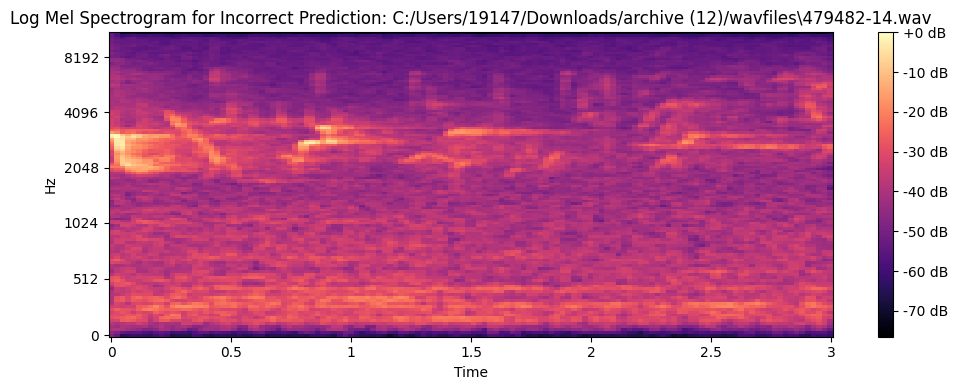

Spectrogram shape: (128, 130)


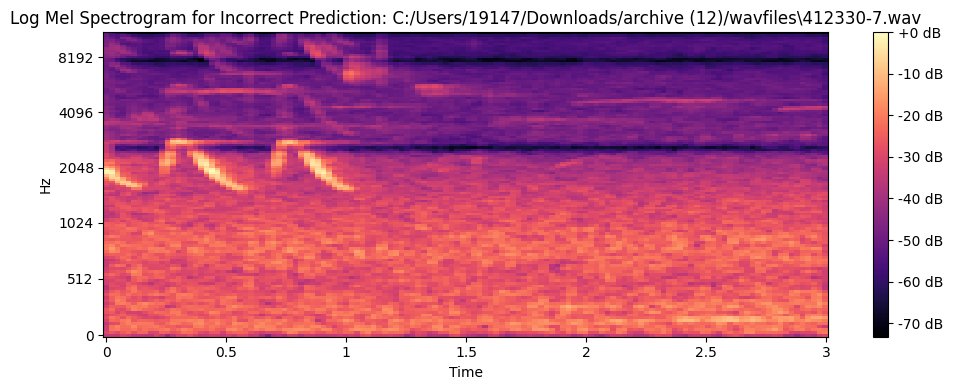

In [19]:
number_to_display = 5  

for index in incorrect_indices_log_Mel[:number_to_display]:
    log_mel_spectrogram = X1_test[index]
    
    # Reshape the flattened spectrogram if necessary
    if log_mel_spectrogram.ndim == 1:
        num_mels = 128
        # Ensure the total length of the array is divisible by num_mels
        time_steps = len(log_mel_spectrogram) // num_mels
        log_mel_spectrogram = log_mel_spectrogram.reshape(num_mels, time_steps)

    file_path = files1_test[index]
    plot_title = f'Log Mel Spectrogram for Incorrect Prediction: {file_path}'
    plot_log_mel_spectrogram(log_mel_spectrogram, plot_title)